# titanic호 탑승객의 생존유무(survived) 예측

In [582]:
import pandas as pd
import numpy as np
import random as rnd

In [583]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [584]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [585]:
%cd C://python

C:\python


In [650]:
import easydict
args = easydict.EasyDict()

# path 정보
args.train_csv = 'titanic/train.csv' 
args.test_csv = 'titanic/test.csv'
args.default_submission_csv = 'titanic/submission.csv'

args.submission_csv ='submission_0405.csv'
args.save_results = "model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 21
args.results = []

## 데이터 불러오기

- survived : 생존=1, 죽음=0
- pclass : 승객 등급. 1등급=1, 2등급=2, 3등급=3
- sibsp : 함께 탑승한 형제 또는 배우자 수
- parch : 함께 탑승한 부모 또는 자녀 수
- ticket : 티켓 번호
- cabin : 선실 번호
- embarked : 탑승장소 S=Southhampton, C=Cherbourg, Q=Queenstown

In [651]:
raw_train = pd.read_csv(args.train_csv) 
raw_test = pd.read_csv(args.test_csv)

raw_train.shape, raw_test.shape   

((916, 12), (393, 11))

In [652]:
raw_train.columns  

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [653]:
raw_train['passengerid'].nunique()

916

In [654]:
#passengerid는 모두 다른 값이므로 삭제
del raw_train['passengerid']

In [655]:
raw_test.set_index(['passengerid'], inplace=True) 
print(f'{raw_test.shape}')

(393, 10)


In [656]:
raw_train.shape , raw_test.shape

((916, 11), (393, 10))

In [657]:
raw_train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [658]:
raw_test.columns

Index(['pclass', 'name', 'gender', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked'],
      dtype='object')

## train_test_split

raw train data -> train, test로 분리

In [659]:
from sklearn.model_selection import train_test_split

In [660]:
train, test = train_test_split(raw_train, test_size=0.3, stratify=raw_train['survived'],random_state=args.random_state) 

In [661]:
train.shape, test.shape

((641, 11), (275, 11))

In [662]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       512 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   cabin     135 non-null    object 
 10  embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 60.1+ KB


In [663]:
train.describe(include='all')

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,641.000000,641.000000,641,641,512.000000,641.000000,641.000000,641,641.000000,135,641
unique,NaN,NaN,641,2,NaN,NaN,NaN,529,NaN,110,3
top,NaN,NaN,"Ohman, Miss. Velin",male,NaN,NaN,NaN,3101295,NaN,B96 B98,S
freq,NaN,NaN,1,407,NaN,NaN,NaN,5,NaN,3,455
mean,0.377535,2.305772,NaN,NaN,30.344082,0.466459,0.368175,NaN,31.654446,NaN,NaN
std,0.485149,0.829221,NaN,NaN,14.492658,0.961386,0.897140,NaN,49.827609,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.400000,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.000000,NaN,NaN


- 이름(Name)은 모두 다르다.
- 성별(gender)은 407/641로 남성이 많다.
- 승선(Embarked)은 총 3개의 종류가 있고, S가 제일 많다.
- 티켓(Ticket)은 중복이 매우 적다.

In [664]:
train.describe(include=np.number)

,survived,pclass,age,sibsp,parch,fare
count,641.000000,641.000000,512.000000,641.000000,641.000000,641.000000
mean,0.377535,2.305772,30.344082,0.466459,0.368175,31.654446
std,0.485149,0.829221,14.492658,0.961386,0.897140,49.827609
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.400000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,30.000000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [665]:
train.describe(exclude=np.number)

,name,gender,ticket,cabin,embarked
count,641,641,641,135,641
unique,641,2,529,110,3
top,"Ohman, Miss. Velin",male,3101295,B96 B98,S
freq,1,407,5,3,455


### EDA

#### Correcting
- 필요없는 column 삭제
> ticket<br>
> cabin은 null값이 많이 존재

In [666]:
print(f'before: {train.shape , test.shape, raw_test.shape}')

#del train['ticket']
#del train['cabin']

#del test['ticket']
#del test['cabin']

#del raw_test['ticket']
#del raw_test['cabin']

print(f'after: {train.shape , test.shape, raw_test.shape}')

before: ((641, 11), (275, 11), (393, 10))
after: ((641, 11), (275, 11), (393, 10))


##### cabin

In [667]:
train.cabin.value_counts()   #2개이상인 데이터 존재

B96 B98            3
D                  3
B57 B59 B63 B66    3
C23 C25 C27        2
C54                2
                  ..
D49                1
A5                 1
C80                1
A19                1
C7                 1
Name: cabin, Length: 110, dtype: int64

In [668]:
c = train.loc[train.cabin.notnull(),'cabin'].map(lambda x : x.split(' '))
c

739         [B20]
738    [B96, B98]
45     [B96, B98]
428         [B49]
471         [C65]
          ...    
472         [D36]
230        [C106]
125         [C86]
641         [E77]
98           [C7]
Name: cabin, Length: 135, dtype: object

In [669]:
c_count = c.map(lambda x : len(x))
c[c_count >= 2]

738              [B96, B98]
45               [B96, B98]
578         [B51, B53, B55]
232                [F, G63]
257    [B57, B59, B63, B66]
249              [B96, B98]
785                [F, E46]
575    [B57, B59, B63, B66]
105              [B58, B60]
466         [C23, C25, C27]
266              [E39, E41]
517              [C62, C64]
112    [B57, B59, B63, B66]
702         [B52, B54, B56]
420              [B58, B60]
190         [B51, B53, B55]
730                [F, E57]
669              [C22, C26]
247              [C55, C57]
365         [C23, C25, C27]
Name: cabin, dtype: object

In [670]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       512 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   cabin     135 non-null    object 
 10  embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 60.1+ KB


In [671]:
train['cabin'] = train['cabin'].str[:2][train['cabin'].notnull()]
test['cabin'] = test['cabin'].str[:2][test['cabin'].notnull()]
raw_test['cabin'] = raw_test['cabin'].str[:2][raw_test['cabin'].notnull()]

In [672]:
train.cabin.value_counts()

C1    12
B5    10
C8     6
B4     6
D3     5
C5     5
E3     5
D1     5
B3     5
C9     5
B2     4
C2     4
E1     4
A2     4
E4     3
B9     3
D4     3
D      3
F      3
C3     3
A1     3
D2     3
B7     2
E5     2
F3     2
C4     2
A3     2
F2     2
C7     2
C6     2
G6     2
B8     2
E6     1
E8     1
B6     1
A6     1
F      1
D7     1
B1     1
E2     1
A5     1
D5     1
E7     1
Name: cabin, dtype: int64

#### pivoting features

In [455]:
#pcalss
train[['pclass','survived']].groupby(['pclass'],as_index=False).mean().sort_values(by='survived',ascending=False)

,pclass,survived
0,1,0.618421
1,2,0.404255
2,3,0.261494


In [456]:
#gender
train[['gender','survived']].groupby(['gender'],as_index=False).mean().sort_values(by='survived',ascending=False)

,gender,survived
0,female,0.816239
1,male,0.125307


In [457]:
#sibsp - 형제,배우자 수
train[['sibsp','survived']].groupby(['sibsp'],as_index=False).mean().sort_values(by='survived',ascending=False)

,sibsp,survived
1,1,0.558442
2,2,0.421053
0,0,0.330317
4,4,0.100000
3,3,0.090909
5,5,0.000000
6,8,0.000000


In [458]:
#parch - 부모,자녀 수
train[['parch','survived']].groupby(['parch'],as_index=False).mean().sort_values(by='survived',ascending=False)

,parch,survived
7,9,1.000000
1,1,0.520548
2,2,0.479167
3,3,0.400000
0,0,0.348515
5,5,0.333333
4,4,0.250000
6,6,0.000000


#### Correlating 
- 상관관계

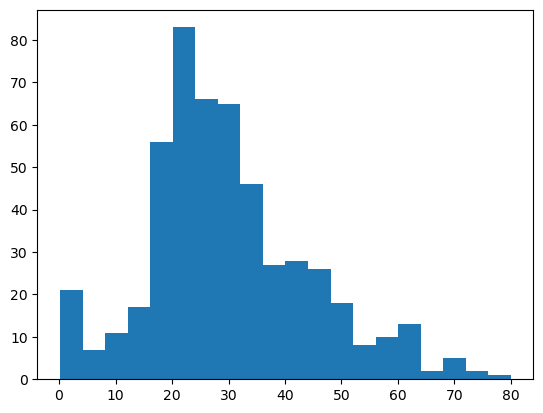

In [459]:
plt.hist(train['age'], bins=20)
plt.show()

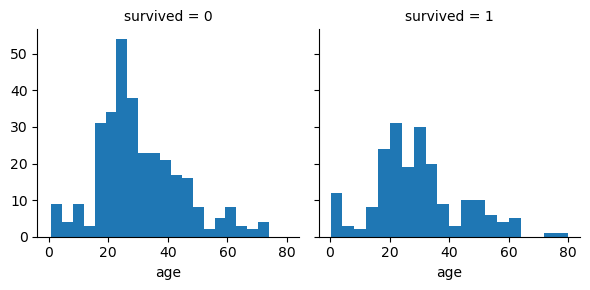

In [460]:
#age
g = sns.FacetGrid(train, col ='survived')
g.map(plt.hist,'age', bins=20)

In [461]:
import logging

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR) 

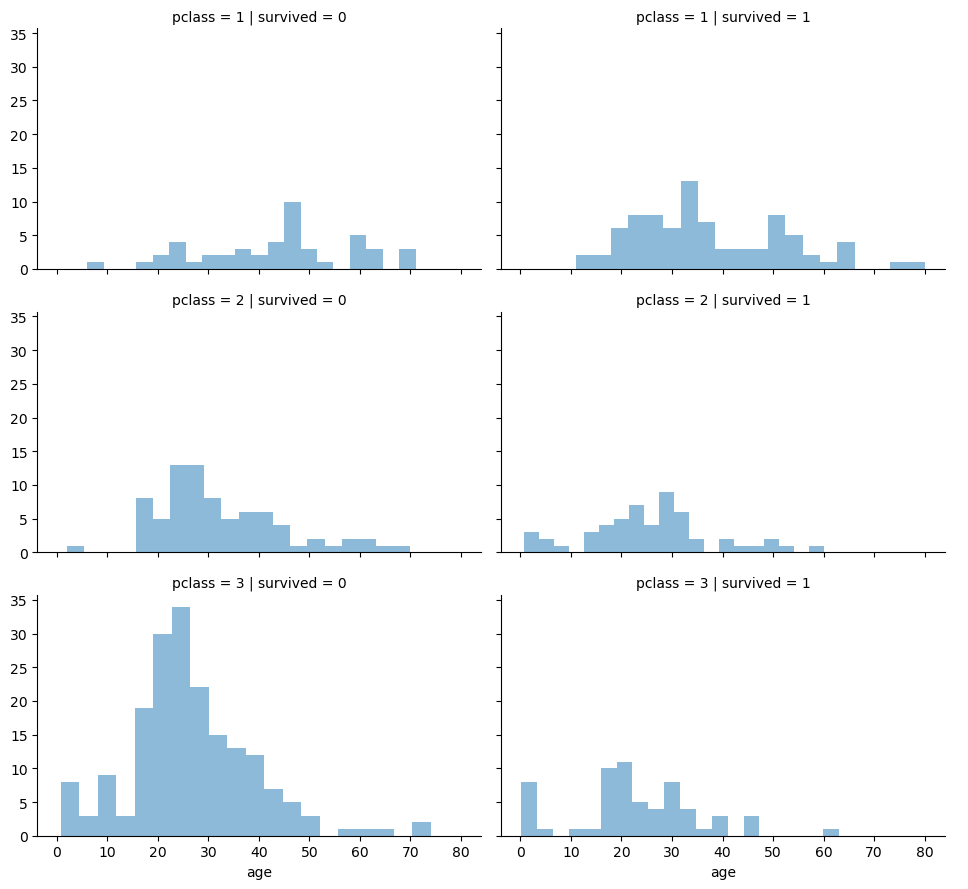

In [462]:
#pclasss
grid = sns.FacetGrid(train,col='survived',row='pclass', aspect=1.6)
grid.map(plt.hist,'age',alpha=.5, bins=20)
grid.add_legend()

- pclass에 따라 승객의 나이 분포 다름
- Pclass=2, Pclass=3에서 영아 승객은 대부분 생존
- Pclass=3인 승객수가 가장 많지만 대다수가 생존하지 못함

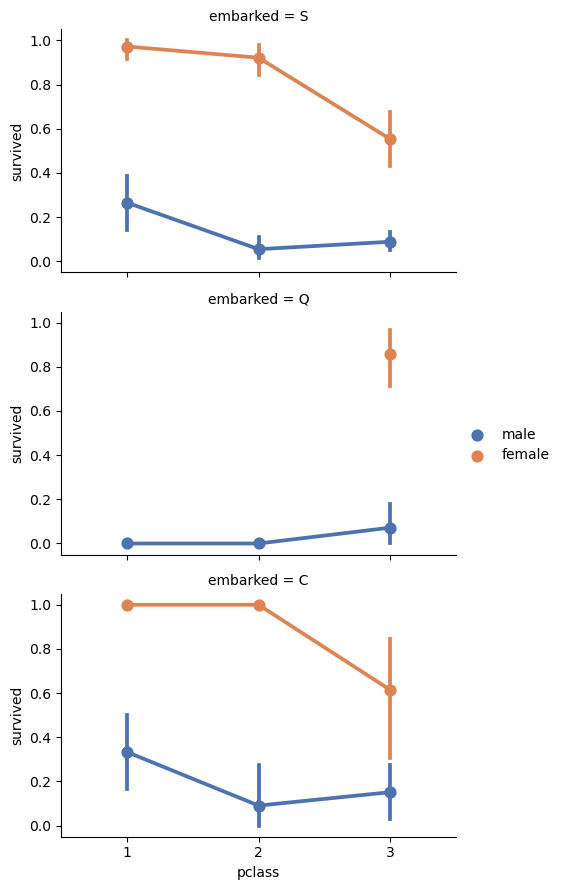

In [463]:
grid = sns.FacetGrid(train, row='embarked',  aspect=1.6)
grid.map(sns.pointplot, 'pclass', 'survived', 'gender', palette='deep',order=[1,2,3], hue_order=["male","female"])
grid.add_legend()

plt.show()

In [464]:
df = train[['gender','pclass','embarked','survived']]
grouped = df.groupby(['embarked','pclass','gender'])
gdf = grouped.mean()
gdf

survived
embarked pclass gender          
C        1      female  1.000000
                male    0.333333
         2      female  1.000000
                male    0.090909
         3      female  0.615385
                male    0.151515
Q        1      male    0.000000
         2      male    0.000000
         3      female  0.857143
                male    0.071429
S        1      female  0.972222
                male    0.265306
         2      female  0.921569
                male    0.054795
         3      female  0.553846
                male    0.088398

- 여성의 생존 비율 높음
- Embarked=S에서 남성 생존 비율 높음

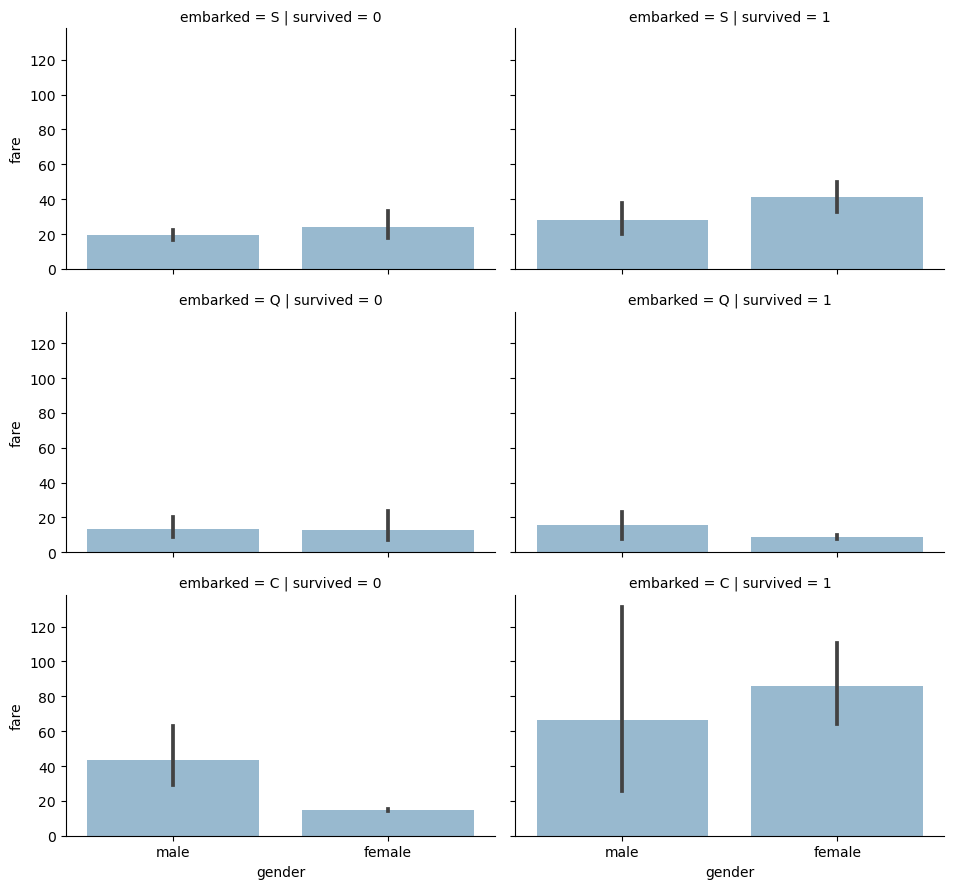

In [465]:
grid = sns.FacetGrid(train, row='embarked', col='survived',  aspect=1.6)
grid.map(sns.barplot, 'gender', 'fare', alpha=.5, order=["male","female"])
grid.add_legend()

plt.show()

#### Missing data

In [466]:
train.isnull().sum() , test.isnull().sum(), raw_test.isnull().sum()

(survived      0
 pclass        0
 name          0
 gender        0
 age         129
 sibsp         0
 parch         0
 ticket        0
 fare          0
 cabin       506
 embarked      0
 dtype: int64,
 survived      0
 pclass        0
 name          0
 gender        0
 age          51
 sibsp         0
 parch         0
 ticket        0
 fare          0
 cabin       212
 embarked      1
 dtype: int64,
 pclass        0
 name          0
 gender        0
 age          83
 sibsp         0
 parch         0
 ticket        0
 fare          1
 cabin       296
 embarked      1
 dtype: int64)

##### age
- title별 age 평균으로 결측치 대체

In [467]:
title_mean = train[['title','age']].groupby(['title'],as_index=False).mean()
title_mean

KeyError: "['title'] not in index"

In [468]:
cond= []

train[cond]

for i in range(len(title_mean.title)):
    train.loc[((train.title.values==title_mean.title[i]) & train['age'].isnull()), 'age'] = title_mean.age[i]
    test.loc[((test.title.values==title_mean.title[i])& test['age'].isnull()),'age'] = title_mean.age[i]
    raw_test.loc[((raw_test.title.values==title_mean.title[i])& raw_test['age'].isnull()),'age'] = title_mean.age[i]

AttributeError: 'DataFrame' object has no attribute 'title'

In [469]:
train['age'].isnull().sum() , test['age'].isnull().sum(), raw_test['age'].isnull().sum()

(129, 51, 83)

##### embarked 
- 최빈값으로 대체

In [470]:
train.embarked.isnull().sum() , test.embarked.isnull().sum(), raw_test.embarked.isnull().sum()

(0, 1, 1)

In [ ]:
train.embarked.value_counts()

In [ ]:
train.embarked.mode().values[0]

In [ ]:
# embarked 결측치는 최빈값으로 대체
test['embarked'].fillna(train.embarked.mode().values[0],inplace = True)
raw_test['embarked'].fillna(train.embarked.mode().values[0],inplace = True)

In [ ]:
train.embarked.isnull().sum() , test.embarked.isnull().sum(), raw_test.embarked.isnull().sum()

##### fare
- 중앙값으로 대체

In [53]:
train.fare.isnull().sum() , test.fare.isnull().sum(), raw_test.fare.isnull().sum()

(0, 0, 1)

In [54]:
#중앙값으로 대체
raw_test['fare'].fillna(train['fare'].median(),inplace=True)

In [55]:
train.fare.isnull().sum() , test.fare.isnull().sum(), raw_test.fare.isnull().sum()

(0, 0, 0)

##### cabin


- 실제 타이타닉호의 선실 구조 
>1등실 : A - E &nbsp;/&nbsp; A,B,C에 대부분 1등실 모여있음 <br>
>2등실 : D - F  <br>
>3등실 : D - G / F에 대부분 3등실 모여있음 
- pclass별 실제 가격 
> 1등실 : 150-870<br>
> 2등실 : 60-72 <br>
> 3등실 : 15-40

In [689]:
train_c= train.copy()
train_c

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,CabinBand
812,1,3,"Ohman, Miss. Velin",female,22.0,0,0,347085,7.7750,NaN,S,NaN
134,0,3,"Buckley, Mr. Daniel",male,21.0,0,0,330920,7.8208,NaN,Q,NaN
390,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S,NaN
305,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,2699,18.7875,NaN,C,NaN
203,0,3,"Corn, Mr. Harry",male,30.0,0,0,SOTON/OQ 392090,8.0500,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
273,1,2,"Davis, Miss. Mary",female,28.0,0,0,237668,13.0000,NaN,S,NaN
343,1,3,"Mulvihill, Miss. Bertha E",female,24.0,0,0,382653,7.7500,NaN,Q,NaN
450,0,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...",male,42.0,0,0,17475,26.5500,NaN,S,NaN
94,0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,NaN


In [691]:
train_c.cabin.isnull().sum() 

506

In [692]:
cond = (train['fare'] >= 184) & (train['cabin'].isnull())
train.loc[cond, 'CabinBand']

341    NaN
451    NaN
550    NaN
Name: CabinBand, dtype: object

In [809]:
letter = 'ABC'
rand = [random.choice(letter) for i in range(len(train[cond]))]
rand

['B', 'B', 'B']

In [810]:
for i in range(len(rand)):
    rand_index = train.loc[cond,'CabinBand'].index[i]
    train['CabinBand'].iloc[rand_index] = rand[i]    
    print(train.loc[cond,'CabinBand'])
    

341    NaN
451    NaN
550    NaN
Name: CabinBand, dtype: object
341    NaN
451    NaN
550    NaN
Name: CabinBand, dtype: object
341    NaN
451    NaN
550    NaN
Name: CabinBand, dtype: object


C:\Users\user\AppData\Local\Temp\ipykernel_6344\3645071504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['CabinBand'].iloc[rand_index] = rand[i]


In [690]:
#cabin 결측치
train.cabin.isnull().sum() , test.cabin.isnull().sum() ,raw_test.cabin.isnull().sum() 

(506, 212, 296)

In [678]:
# pclass별 fare
train[['pclass','fare']].groupby(by='pclass').describe()

fare                                                                
        count       mean        std  min    25%      50%        75%       max
pclass                                                                       
1       152.0  84.025220  80.094790  0.0  30.00  56.9292  91.684400  512.3292
2       141.0  20.599437  12.845749  0.0  13.00  15.0458  26.000000   73.5000
3       348.0  13.259039  11.427055  0.0   7.75   8.0500  14.468725   69.5500

In [679]:
train['CabinBand'] = CabinBand = train['cabin'].str[:1][train['cabin'].notnull()]

In [680]:
#pclass, cabinband별 생존율

train[['CabinBand','pclass','survived']].groupby(by=['pclass','CabinBand'],as_index=False).mean()

,pclass,CabinBand,survived
0,1,A,0.454545
1,1,B,0.705882
2,1,C,0.634146
3,1,D,0.764706
4,1,E,0.692308
5,2,D,0.250000
6,2,E,0.666667
7,2,F,0.600000
8,3,E,1.000000
9,3,F,0.000000


In [681]:
train[['CabinBand','survived']].groupby(by='CabinBand',as_index=False).mean()

,CabinBand,survived
0,A,0.454545
1,B,0.705882
2,C,0.634146
3,D,0.666667
4,E,0.722222
5,F,0.375000
6,G,0.500000


- 선실별 생존율
> F < A < G < C < D < B < E

>> 3등석인 F와 G선실의 생존율 낮고 / 1등석이지만 A호실이 생존율이 두번째로 낮음<br>
>> Pclass내에서도 Cabin별로 생존율이 상의하다.

이상치

In [682]:
pclass_1 = train.loc[train['pclass']== 1,'fare']
pclass_2 = train.loc[train['pclass']== 2,'fare']
pclass_3 = train.loc[train['pclass']== 3,'fare']

In [683]:
def outlier(data):
    quantile =  data.quantile([0.25,0.75])
    iqr = quantile.values[1]-quantile.values[0]
    Upper_boundary = quantile.values[1] + 1.5*iqr
    Lower_boundary = quantile.values[0] - 1.5*iqr
    return Lower_boundary,Upper_boundary

In [684]:
print(f'outlier_1 : {outlier(pclass_1)}')
print(f'outlier_2 : {outlier(pclass_2)}')
print(f'outlier_3 : {outlier(pclass_3)}')

outlier_1 : (-62.5266, 184.211)
outlier_2 : (-6.5, 45.5)
outlier_3 : (-2.3280874999999988, 24.546812499999998)


<AxesSubplot:xlabel='pclass', ylabel='fare'>

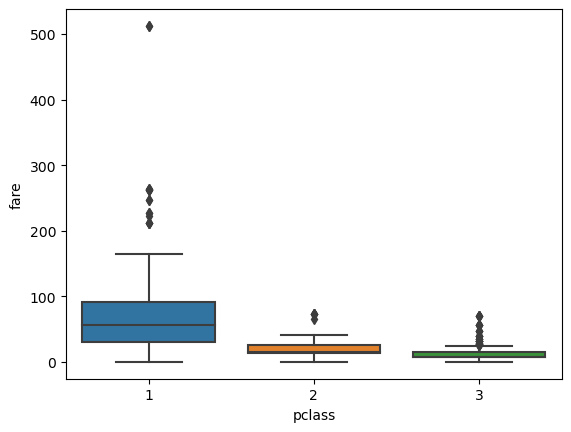

In [685]:
sns.boxplot(x='pclass',y='fare',data=train)

<AxesSubplot:xlabel='fare', ylabel='CabinBand'>

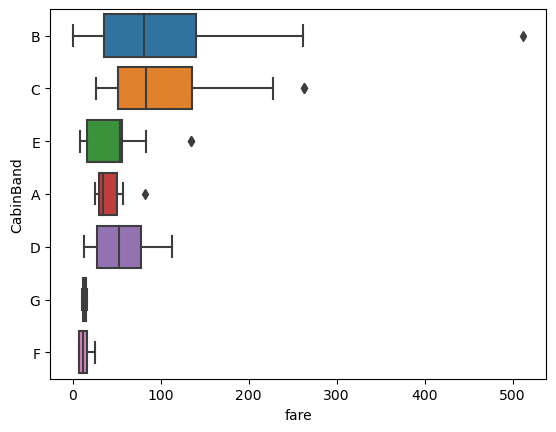

In [618]:
sns.boxplot(x=train['fare'],y=train['CabinBand'],data=train)

> 실제 가격 정보와 이상치 정보를 합쳐서 cabin값 대체
- 1등실 
> 73-183까지는 A-E로 랜덤배정<br>
> 184부터는 A-C로 랜덤배정<br>

- 2등실<br>
> 41-72까지 D-F로 랜덤배정<br>

- 3등실<br>
> 0-24까지 F-G로 랜덤배정<br>
> 25-40까지는 D-E로 랜덤배정


In [619]:
cond = (train['fare'] >= 184) & (train['cabin'].isnull())
train.loc[cond, 'CabinBand']

341    NaN
451    NaN
550    NaN
Name: CabinBand, dtype: object

In [620]:
len(train[cond])

3

In [625]:
train.loc[cond,'CabinBand']

341    NaN
451    NaN
550    NaN
Name: CabinBand, dtype: object

In [643]:
rand = [random.choice(letter) for i in range(len(train[cond]))]
rand

['A', 'A', 'C']

In [644]:
rand[0]

'A'

In [647]:
for i in range(len(rand)):
    train.loc[cond,'CabinBand'] = rand[i]
    

In [648]:
train[cond]

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,CabinBand
341,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,C
451,0,1,"Robbins, Mr. Victor",male,NaN,0,0,PC 17757,227.5250,NaN,C,C
550,1,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S,C


In [649]:
letter = 'ABC'
for i in range(len(train[cond])):
    train['CabinBand'] = random.choice(letter)

In [533]:
letter = 'ABC'
train.loc[cond, 'CabinBand'] = random.choice(letter)

In [487]:
letter = 'FG'
train.loc[(train['fare']<=24)&(train['cabin'].isnull()),'cabin'] = random.choice(letter)

In [495]:
train.loc[(train['fare']>24)&(train['fare']<=40)&(train['cabin'].isnull()),'cabin']

Series([], Name: cabin, dtype: object)

In [493]:
str = 'DE'
train.loc[(train['fare']>24)&(train['fare']<=40)&(train['cabin'].isnull()),'cabin'] = random.choice(str)

In [494]:
train.loc[(train['fare']>24)&(train['fare']<=40)&(train['cabin'].isnull()),'cabin']

Series([], Name: cabin, dtype: object)

In [500]:
train.loc[(train['fare']>24)&(train['fare']<=40),'cabin'].value_counts()

D     89
C1     5
A1     3
F2     2
C5     2
B3     2
B4     2
A2     2
C8     1
A5     1
D2     1
D1     1
C4     1
D5     1
B2     1
B5     1
D4     1
E6     1
E2     1
A6     1
Name: cabin, dtype: int64

In [337]:
cabin_fare = train.loc[train.cabin.notnull(),['cabin','pclass','fare']].groupby(by='cabin',as_index=False).agg(['min','max','mean','median','count'])
cabin_fare

pclass                            fare                                   \
         min max mean median count       min       max        mean     median   
cabin                                                                           
A1         1   1  1.0    1.0     3   26.0000   29.7000   27.806933   27.72080   
A2         1   1  1.0    1.0     4   30.0000   56.9292   41.981250   40.49790   
A3         1   1  1.0    1.0     2   50.0000   81.8583   65.929150   65.92915   
A5         1   1  1.0    1.0     1   34.6542   34.6542   34.654200   34.65420   
A6         1   1  1.0    1.0     1   35.5000   35.5000   35.500000   35.50000   
B1         1   1  1.0    1.0     1    0.0000    0.0000    0.000000    0.00000   
B2         1   1  1.0    1.0     4   26.5500   71.0000   56.387500   64.00000   
B3         1   1  1.0    1.0     5   26.5500   69.3000   47.405840   49.50000   
B4         1   1  1.0    1.0     6   27.7208   91.0792   66.890983   80.73335   
B5         1   1  1.0    1.0    10    0.0000  512.3292  204.133330  247.52080   
B6         1   1  1.0    1.0     1   93.5000   93.5000   93.500000   93.50000   
B7         1   1  1.0    1.0     2   93.5000  146.5208  120.010400  120.01040   
B8         1   1  1.0    1.0     2   79.2000  146.5208  112.860400  112.86040   
B9         1   1  1.0    1.0     3  120.0000  120.0000  120.000000  120.00000   
C1         1   1  1.0    1.0    12   26.5500  211.5000   64.390975   51.73960   
C2         1   1  1.0    1.0     4   66.6000  263.0000  186.037500  207.27500   
C3         1   1  1.0    1.0     3   60.0000  135.6333  110.422200  135.63330   
C4         1   1  1.0    1.0     2   29.7000   78.8500   54.275000   54.27500   
C5         1   1  1.0    1.0     5   28.5000  221.7792   89.026660   83.15830   
C6         1   1  1.0    1.0     2  108.9000  227.5250  168.212500  168.21250   
C7         1   1  1.0    1.0     2   90.0000  164.8667  127.433350  127.43335   
C8         1   1  1.0    1.0     6   26.5500  211.5000  102.975000   94.95000   
C9         1   1  1.0    1.0     5   89.1042  153.4625  102.334180   90.00000   
D          2   2  2.0    2.0     3   12.8750   15.0458   13.640267   13.00000   
D1         1   1  1.0    1.0     5   25.9292   77.9583   57.057520   52.55420   
D2         1   1  1.0    1.0     3   39.4000   78.2667   64.984733   77.28750   
D3         1   2  1.2    1.0     5   13.8625  113.2750   66.334180   75.25000   
D4         1   1  1.0    1.0     3   27.7208  113.2750   72.575000   76.72920   
D5         1   1  1.0    1.0     1   32.3208   32.3208   32.320800   32.32080   
D7         1   1  1.0    1.0     1   77.9583   77.9583   77.958300   77.95830   
E1         2   3  2.5    2.5     4    8.0500   13.0000   11.006250   11.48750   
E2         1   1  1.0    1.0     1   26.3875   26.3875   26.387500   26.38750   
E3         1   1  1.0    1.0     5   55.0000  134.5000   88.420840   61.17500   
E4         1   1  1.0    1.0     3   51.8625   83.1583   63.640267   55.90000   
E5         1   1  1.0    1.0     2   55.4417   55.4417   55.441700   55.44170   
E6         1   1  1.0    1.0     1   38.5000   38.5000   38.500000   38.50000   
E7         2   2  2.0    2.0     1   10.5000   10.5000   10.500000   10.50000   
E8         1   1  1.0    1.0     1   53.1000   53.1000   53.100000   53.10000   
F          2   2  2.0    2.0     1   13.0000   13.0000   13.000000   13.00000   
F          3   3  3.0    3.0     3    7.2292    7.6500    7.369467    7.22920   
F2         2   2  2.0    2.0     2   26.0000   26.0000   26.000000   26.00000   
F3         2   2  2.0    2.0     2   10.5000   13.0000   11.750000   11.75000   
G6         3   3  3.0    3.0     2   10.4625   16.7000   13.581250   13.58125   

             
      count  
cabin        
A1        3  
A2        4  
A3        2  
A5        1  
A6        1  
B1        1  
B2        4  
B3        5  
B4        6  
B5       10  
B6        1  
B7        2  
B8        2  
B9        3  
C1       12  
C2        4  
C3        3  

In [236]:
train['CabinBand'].value_counts()

C    41
B    34
D    21
E    18
A    11
F     8
G     2
Name: CabinBand, dtype: int64

- 선실별 생존율
> F < A < G < C < D < B < E

>> 3등석인 F와 G선실의 생존율 낮고 / 1등석이지만 A호실이 생존율이 두번째로 낮음<br>
>> Pclass내에서도 Cabin별로 생존율이 상의하다.

- pclass안에서 cabin이 나뉘는 기준이 뭘까..?
- 왜 cabin별로 생존율 차이가 심할까..?


In [407]:
cabin_cat = train[['CabinBand','fare','pclass']].groupby(by=['CabinBand','pclass']).describe()
cabin_cat

fare                                                        \
                 count        mean         std      min        25%       50%   
CabinBand pclass                                                               
A         1       11.0   41.214391   17.101465  26.0000  29.850000  34.65420   
B         1       34.0  112.485294  106.581257   0.0000  35.250000  80.73335   
C         1       41.0  100.551322   68.221087  26.5500  52.000000  83.47500   
D         1       17.0   66.238488   26.112332  25.9292  52.554200  76.29170   
          2        4.0   13.695825    1.001356  12.8750  12.968750  13.43125   
E         1       13.0   66.299685   32.813798  26.3875  53.100000  55.44170   
          2        3.0   11.333333    1.443376  10.5000  10.500000  10.50000   
          3        2.0   10.262500    3.128948   8.0500   9.156250  10.26250   
F         2        5.0   17.700000    7.645260  10.5000  13.000000  13.00000   
          3        3.0    7.369467    0.242949   7.2292   7.229200   7.22920   
G         3        2.0   13.581250    4.410579  10.4625  12.021875  13.58125   

                                        
                         75%       max  
CabinBand pclass                        
A         1        50.247900   81.8583  
B         1       139.890600  512.3292  
C         1       135.633300  263.0000  
D         1        77.958300  113.2750  
          2        14.158325   15.0458  
E         1        61.175000  134.5000  
          2        11.750000   13.0000  
          3        11.368750   12.4750  
F         2        26.000000   26.0000  
          3         7.439600    7.6500  
G         3        15.140625   16.7000

In [313]:
cabin_BC = cabin_cat[1:3]
cabin_FG = cabin_cat[5:8]

In [314]:
cabin_BC

fare                           
                 mean    median    min       max
CabinBand                                       
B          112.485294  80.73335   0.00  512.3292
C          100.551322  83.47500  26.55  263.0000

In [ ]:
train[['

In [331]:
train.loc[(train['CabinBand']=='A') | (train['CabinBand']=='E'),['cabin','pclass','fare']].groupby(by='cabin',as_index=False).agg(['mean','min','max'])

pclass               fare                   
        mean min max       mean      min       max
cabin                                             
A1       1.0   1   1  27.806933  26.0000   29.7000
A2       1.0   1   1  41.981250  30.0000   56.9292
A3       1.0   1   1  65.929150  50.0000   81.8583
A5       1.0   1   1  34.654200  34.6542   34.6542
A6       1.0   1   1  35.500000  35.5000   35.5000
E1       2.5   2   3  11.006250   8.0500   13.0000
E2       1.0   1   1  26.387500  26.3875   26.3875
E3       1.0   1   1  88.420840  55.0000  134.5000
E4       1.0   1   1  63.640267  51.8625   83.1583
E5       1.0   1   1  55.441700  55.4417   55.4417
E6       1.0   1   1  38.500000  38.5000   38.5000
E7       2.0   2   2  10.500000  10.5000   10.5000
E8       1.0   1   1  53.100000  53.1000   53.1000

In [350]:
train.pclass.value_counts()

3    348
1    152
2    141
Name: pclass, dtype: int64

In [361]:
pclass_3 = train.loc[train['pclass']==3, ['pclass','fare']]

In [365]:
pclass_3 = train.loc[train['pclass']==3, 'fare']

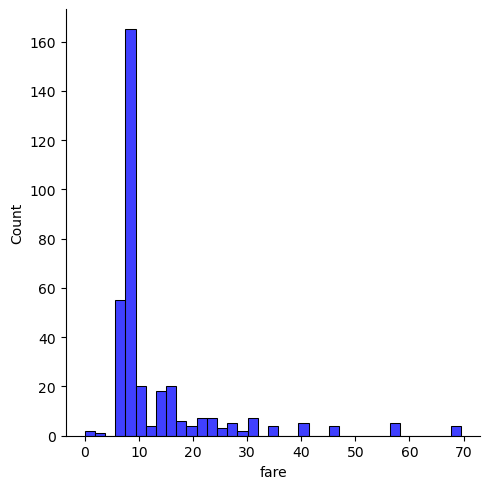

In [366]:
sns.displot(pclass_3 , color = 'b', label ='Skewness : %.2f'%(pclass_3.skew()))

<AxesSubplot:xlabel='pclass', ylabel='fare'>

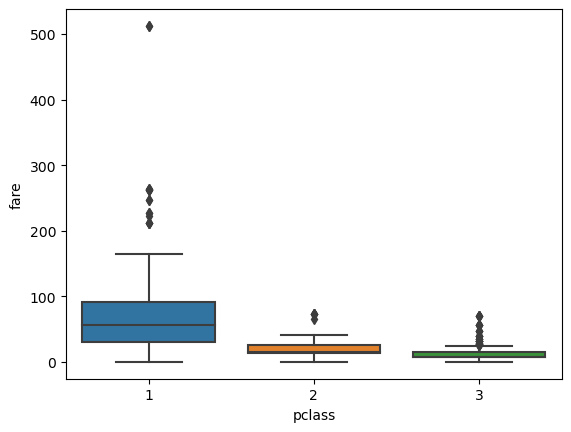

In [353]:
sns.boxplot(x='pclass',y='fare',data=train)

In [368]:
train.groupby(['pclass'])['fare'].quantile([0.25,0.75])

pclass      
1       0.25    30.000000
        0.75    91.684400
2       0.25    13.000000
        0.75    26.000000
3       0.25     7.750000
        0.75    14.468725
Name: fare, dtype: float64

In [371]:
pclass_1 = train.loc[train['pclass']== 1,'fare']
pclass_2 = train.loc[train['pclass']== 2,'fare']
pclass_3 = train.loc[train['pclass']== 3,'fare']

In [402]:
def outlier(data):
    quantile =  data.quantile([0.25,0.75])
    iqr = quantile.values[1]-quantile.values[0]
    Upper_boundary = quantile.values[1] + 1.5*iqr
    Lower_boundary = quantile.values[0] - 1.5*iqr
    return Lower_boundary,Upper_boundary

In [404]:
print(f'outlier_1 : {outlier(pclass_1)}')
print(f'outlier_2 : {outlier(pclass_2)}')
print(f'outlier_3 : {outlier(pclass_3)}')

outlier_1 : (-62.5266, 184.211)
outlier_2 : (-6.5, 45.5)
outlier_3 : (-2.3280874999999988, 24.546812499999998)


<AxesSubplot:xlabel='fare', ylabel='CabinBand'>

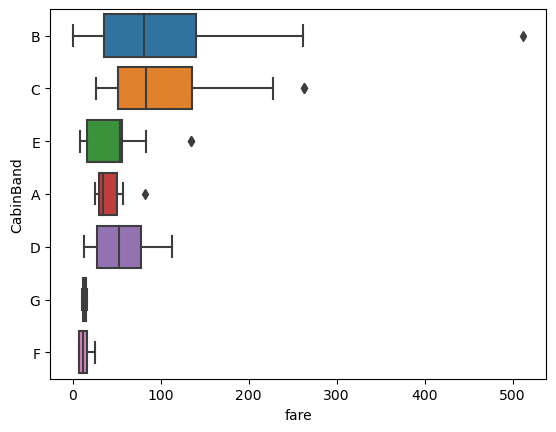

In [330]:
sns.boxplot(x=train['fare'],y=train['CabinBand'],data=df)

In [ ]:
- 선실별 비용 중앙값
1emd : A < D < E < B < C
2

<AxesSubplot:xlabel='pclass', ylabel='survived'>

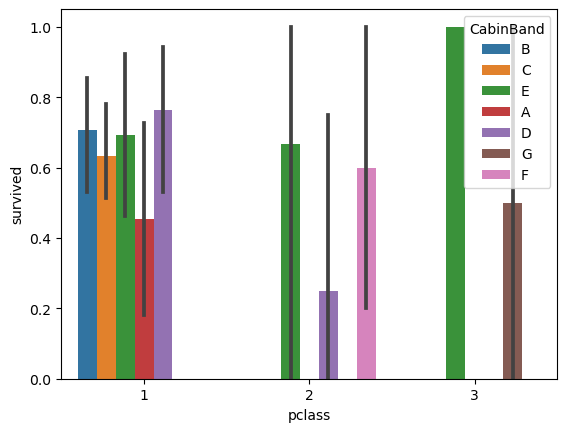

In [247]:
sns.barplot(x='pclass',y='survived',hue='CabinBand',data=train)

In [138]:
train.loc[(train.pclass==1)&(train.cabin.notnull()),'cabin'].value_counts()

C    41
B    34
D    17
E    13
A    11
Name: cabin, dtype: int64

In [181]:
train.cabin.unique()

array([nan, 'B', 'C', 'E', 'A', 'D', 'G', 'F'], dtype=object)

<AxesSubplot:xlabel='fare', ylabel='cabin'>

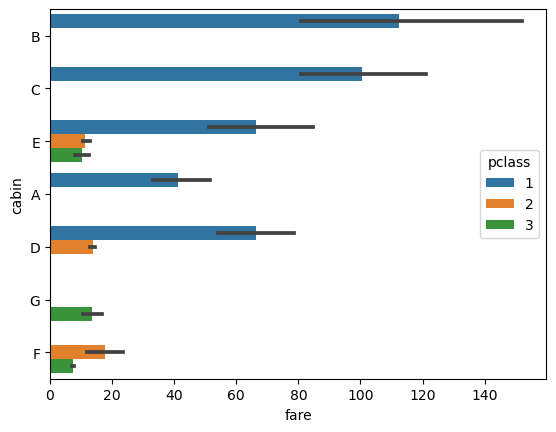

In [189]:
sns.barplot(data=train,x='fare',y='cabin',hue='pclass')

In [102]:
cabin_fare_max.fare.sort_values()

cabin
G     16.7000
F     26.0000
A     81.8583
D    113.2750
E    134.5000
C    263.0000
B    512.3292
Name: fare, dtype: float64

#### New Features 

##### name title

In [73]:
train.name

812                                   Ohman, Miss. Velin
134                                  Buckley, Mr. Daniel
390                                    Jonsson, Mr. Carl
305                             Hassan, Mr. Houssein G N
203                                      Corn, Mr. Harry
                             ...                        
273                                    Davis, Miss. Mary
343                            Mulvihill, Miss. Bertha E
450    Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...
94                          Panula, Master. Urho Abraham
277                               Hunt, Mr. George Henry
Name: name, Length: 641, dtype: object

In [74]:
print(f'before: {train.shape , test.shape , raw_test.shape}')

train['title'] = train.name.map(lambda x : x.split(',')[1].split('.')[0])
test['title'] = test.name.map(lambda x : x.split(',')[1].split('.')[0])
raw_test['title'] = raw_test.name.map(lambda x : x.split(',')[1].split('.')[0])

print(f'after: {train.shape , test.shape , raw_test.shape}')

before: ((641, 11), (275, 11), (393, 10))
after: ((641, 12), (275, 12), (393, 11))


In [75]:
train.title.value_counts()

 Mr          370
 Miss        126
 Mrs         106
 Master       22
 Rev           4
 Dr            3
 Col           3
 Major         2
 Capt          1
 Mlle          1
 Ms            1
 Sir           1
 Jonkheer      1
Name: title, dtype: int64

In [76]:
list(train['title'].value_counts().index[:3])

[' Mr', ' Miss', ' Mrs']

In [77]:
def add_title(title):
    result = 'Other'
    try:
        if title in list(train['title'].value_counts().index[:3]):
            return title
        else:
            return result
    except:
        return result
    
train['title'] = train['title'].map(lambda x : add_title(x))
test['title'] = test['title'].map(lambda x : add_title(x))
raw_test['title'] = raw_test['title'].map(lambda x : add_title(x))

In [78]:
train['title'].unique(), test['title'].unique(), raw_test['title'].unique()

(array([' Miss', ' Mr', ' Mrs', 'Other'], dtype=object),
 array([' Mr', 'Other', ' Miss', ' Mrs'], dtype=object),
 array([' Miss', ' Mrs', ' Mr', 'Other'], dtype=object))

In [79]:
train['title'] = train['title'].map(lambda x : x.strip())
test['title'] = test['title'].map(lambda x : x.strip())
raw_test['title'] = raw_test['title'].map(lambda x : x.strip())

In [80]:
train.title.unique()

array(['Miss', 'Mr', 'Mrs', 'Other'], dtype=object)

In [81]:
#name 삭제
print(f'before: {train.shape , test.shape , raw_test.shape}')

del train['name']
del test['name']
del raw_test['name']

print(f'after: {train.shape , test.shape , raw_test.shape}')

before: ((641, 12), (275, 12), (393, 11))
after: ((641, 11), (275, 11), (393, 10))


##### age 
- 연령대별로 범주화

In [82]:
train['AgeBand'] = pd.cut(train['age'],5)
train[['AgeBand','survived']].groupby(['AgeBand'],as_index=False).agg(['mean','sum','count'])

survived           
                      mean  sum count
AgeBand                              
(0.0902, 16.136]  0.446429   25    56
(16.136, 32.102]  0.385185  104   270
(32.102, 48.068]  0.330709   42   127
(48.068, 64.034]  0.510204   25    49
(64.034, 80.0]    0.200000    2    10

In [ ]:
#age를 범주형으로 변환
for dataset in combine:    
    dataset.loc[ dataset['age'] <= 16, 'age'] = 0
    dataset.loc[(dataset['age'] > 16) & (dataset['age'] <= 32), 'age'] = 1
    dataset.loc[(dataset['age'] > 32) & (dataset['age'] <= 48), 'age'] = 2
    dataset.loc[(dataset['age'] > 48) & (dataset['age'] <= 64), 'age'] = 3
    dataset.loc[ dataset['age'] > 64, 'age'] = 4
train.head()

In [ ]:
train.info()

In [ ]:
#age type 변경
train['age']=train.age.astype('int64')
test['age']=test.age.astype('int64')
raw_test['age']=raw_test.age.astype('int64')
train.info()

In [ ]:
train[['age','AgeBand']]  #확인

In [ ]:
# AgeBand 삭제
del train['AgeBand']

##### FamilySize 
- parch와 sibsp 이용

In [ ]:
print(f'before: {train.shape , test.shape , raw_test.shape}')

combine = [train, test , raw_test]
for dataset in combine:
    dataset['FamilySize'] = dataset['parch'] + dataset['sibsp'] + 1 

train[['FamilySize','survived']].groupby(['FamilySize'],as_index=False).mean().sort_values(by='survived',ascending=False)

print(f'after: {train.shape , test.shape , raw_test.shape}')

##### IsAlone

- 1인가구인지?

In [ ]:
print(f'before: {train.shape , test.shape , raw_test.shape}')

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1,'IsAlone']=1

print(f'after: {train.shape , test.shape , raw_test.shape}')

In [ ]:
train[['IsAlone','survived']].groupby(['IsAlone'],as_index=False).mean()

### Data Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train.describe(exclude=np.number)  #범주형

In [ ]:
train.isnull().sum().sum() ,test.isnull().sum().sum(), raw_test.isnull().sum().sum()

In [ ]:
enc_cols = ['gender','embarked','title']
normal_cols = train.columns.difference(['gender','embarked','title'])

#raw_test용 (survived를 제외시킨 column)
normal_cols_ori = normal_cols      
normal_cols_ori = normal_cols_ori.drop('survived')

normal_cols , normal_cols_ori

In [ ]:
print(f'before: {train.shape} / {test.shape} / {enc_raw_te.shape}')

enc = OneHotEncoder()

#train
tmp_tr = pd.DataFrame(                              
    enc.fit_transform(train[enc_cols]).toarray(),   
    columns = enc.get_feature_names_out()           
)
enc_tr = pd.concat(
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]    
    , axis=1
)

# # test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

# raw_test
tmp_te = pd.DataFrame(
    enc.transform(raw_test[enc_cols]).toarray(), 
    columns = enc.get_feature_names_out()
)

enc_raw_te = pd.concat(
    [raw_test[normal_cols_ori].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape} / {enc_raw_te.shape}')
enc_te.head()

#### target, feature 분리

In [ ]:
#enc_tr
y_tr = enc_tr['survived']                   #타겟 데이터
X_tr = enc_tr.drop(['survived'], axis=1)    #Feature 데이터만

In [ ]:
X_tr.head()

In [ ]:
#enc_te
y_te = enc_te['survived']                   #타겟 데이터
X_te = enc_te.drop(['survived'], axis=1)    #Feature 데이터만

In [ ]:
print(f'after: {X_tr.shape} / {X_te.shape} / {enc_raw_te.shape}')

### Training

#### CatBoost


In [ ]:
# !pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}

model1 = CatBoostClassifier(**hp).fit(X_tr, y_tr)

In [ ]:
#AUC
from sklearn.metrics import roc_curve, auc 

y_pred = model1.predict_proba(X_te)[:,1]   # 예측값 / proba : 확률 예측  > 0과 1사이에 있는 값이 나옴 > 이 값을 submit 파일에 올리면 됨
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

#### Light GBM

In [ ]:
from lightgbm import LGBMClassifier ,plot_importance

model2 = LGBMClassifier(random_state=42).fit(X_tr,y_tr)

In [ ]:
from sklearn.metrics import roc_curve, auc

#AUC
y_pred = model2.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

In [ ]:
plot_importance(model2)
plt.show()

#### XGboost

In [ ]:
from xgboost import XGBClassifier ,plot_importance

model3 = XGBClassifier(random_state=42).fit(X_tr,y_tr)

In [ ]:
X_tr.shape , y_tr.shape , enc_te.shape

In [ ]:
y_pred = model3.predict_proba(X_te)[:,1]

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = model3.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

In [ ]:
plot_importance(model3)
plt.show()

### Submission

In [ ]:
#model1 사용
ori_te_pred = model1.predict_proba(enc_raw_te)[:,1]
ori_te_pred.shape

In [ ]:
ori_te_pred

In [ ]:
submission['survived'] = ori_te_pred
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

In [ ]:
#submission.to_csv(args.submission_csv, header=True, index=False)